## Modelagem de tópicos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
from wordcloud import WordCloud

In [2]:
df = pd.read_parquet('dados/id_desc_clr.parquet')
df.shape

(3452, 6)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3452 entries, 0 to 3615
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                3452 non-null   object
 1   desc              3452 non-null   object
 2   desc_sent         3452 non-null   object
 3   desc_token_clr    3452 non-null   object
 4   desc_bigram_clr   3452 non-null   object
 5   desc_trigram_clr  3452 non-null   object
dtypes: object(6)
memory usage: 188.8+ KB


### LDA

In [4]:
# Lematização
lemmatizer = WordNetLemmatizer()
df['desc_token_lemma'] = df['desc_token_clr'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

In [5]:
# Cria um corpus a partir de um dicionário
dictionary = corpora.Dictionary(df['desc_token_lemma'])
corpus = [dictionary.doc2bow(text) for text in df['desc_token_lemma']]

# Salva o corpus para uso futuro
#corpora.MmCorpus.serialize('dados/corpus.mm', corpus)

In [6]:
# Carrega o corpus
#corpus = corpora.MmCorpus('corpus.mm')

In [8]:
# Calcular a coerência para cada número de tópicos
num_topics_list = list(range(2, 11))
coherence_scores = []
for num_topics in num_topics_list:
    lda_model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=2)
    coherence_model_lda = models.CoherenceModel(model=lda_model, texts=df['desc_token_lemma'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)

# Encontrar o número ideal de tópicos (maior coerência)
best_num_topics = num_topics_list[np.argmax(coherence_scores)]
print("O número ideal de tópicos é:", best_num_topics)

O número ideal de tópicos é: 6


In [9]:
# Criar o modelo LDA com o número ideal de tópicos
lda_model = models.LdaModel(corpus=corpus, num_topics=best_num_topics, id2word=dictionary, passes=10)
for topic in lda_model.print_topics():
    print(topic)

(0, '0.015*"health" + 0.015*"company" + 0.013*"read" + 0.012*"patient" + 0.010*"care" + 0.010*"healthcare" + 0.010*"data" + 0.009*"platform" + 0.008*"service" + 0.007*"solution"')
(1, '0.015*"customer" + 0.015*"platform" + 0.012*"read" + 0.010*"company" + 0.010*"data" + 0.010*"ai" + 0.007*"brand" + 0.007*"business" + 0.006*"digital" + 0.006*"solution"')
(2, '0.022*"data" + 0.012*"company" + 0.011*"read" + 0.010*"technology" + 0.010*"ai" + 0.007*"platform" + 0.007*"world" + 0.005*"customer" + 0.004*"team" + 0.004*"business"')
(3, '0.008*"read" + 0.007*"brand" + 0.007*"customer" + 0.006*"online" + 0.006*"retailer" + 0.006*"platform" + 0.005*"product" + 0.005*"logistics" + 0.004*"return" + 0.004*"delivery"')
(4, '0.013*"company" + 0.012*"business" + 0.012*"platform" + 0.011*"read" + 0.011*"service" + 0.010*"solution" + 0.010*"security" + 0.008*"payment" + 0.007*"management" + 0.007*"cloud"')
(5, '0.009*"company" + 0.009*"disease" + 0.008*"drug" + 0.006*"therapeutic" + 0.006*"development" 

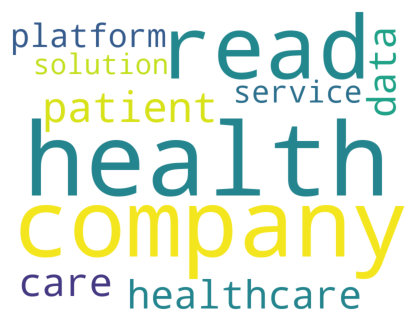

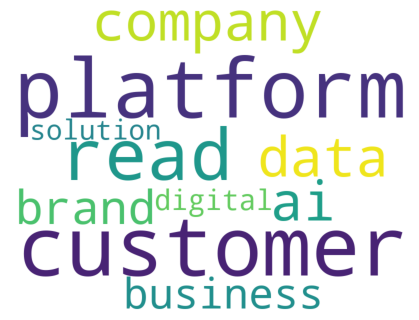

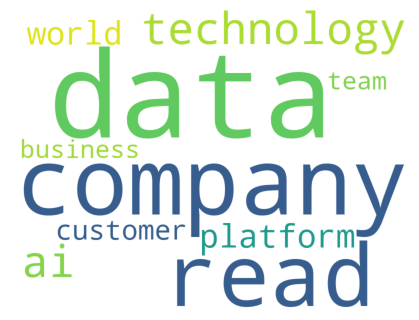

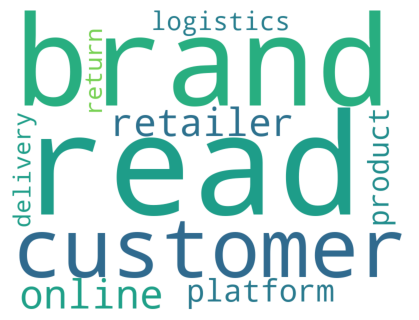

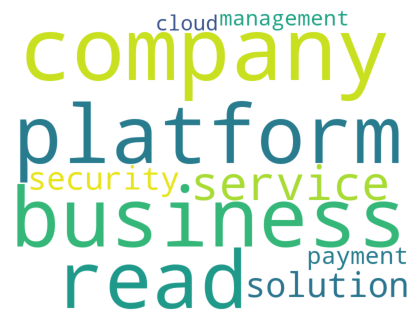

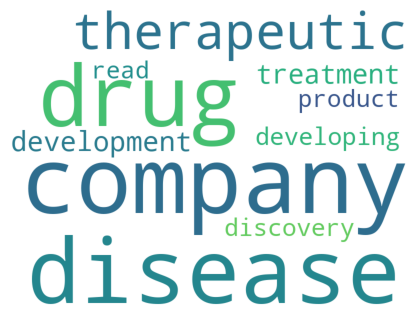

In [10]:
# Criar uma word cloud para cada tópico
for topic in lda_model.show_topics():
    topic_words = dict(lda_model.show_topic(topic[0]))
    wordcloud = WordCloud(width=800, height=600, background_color='white', min_font_size=10) \
                .generate_from_frequencies(topic_words)
    
    plt.figure(figsize=(4, 3), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()